[과제] bike_train.csv를 불어와서 다음 사항들을 고려하여 자전거 대여횟수를 예측하는 모델을 생성 후 평가하세요.

- datetime 타입에서 년, 월, 일, 시간 추출하여 반영 후 선형회귀 모델링 및 평가 
    - 사용자 함수 : RMSLE, RMSE, MAE
- 종속변수 정규성 개선위한 로그 변환
    - 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
    - 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할 
    - 선형회귀, ridge, lasso model 별로 평가 수행
    - 회귀계수 중요도 시각화


In [ ]:
import sklearn.metrics
sorted(sklearn.metrics.SCORERS.keys())

In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('./dataset/bike_train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [48]:
# datetime을 datetime으로 변경할 필요가 있음
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [49]:
# str -> datetime 
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)

In [50]:
# casual은 사전에 등록되지 않은 사용자가 대여한 횟수,
# registered는 사전에 등록도니 사용자가 대여한 횟수를 의미하는데, 이 둘의 합이 count이므로 삭제톨록 한다.
bike_df.corr()['count'].sort_values(ascending=False)

count         1.000000
registered    0.970948
casual        0.690414
hour          0.400601
temp          0.394454
atemp         0.389784
year          0.260403
month         0.166862
season        0.163439
windspeed     0.101369
day           0.019826
workingday    0.011594
holiday      -0.005393
weather      -0.128655
humidity     -0.317371
Name: count, dtype: float64

In [51]:
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1,inplace=True)

In [52]:
# 모델평가 사용자 함수
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error

# log 변환하는 과정중에 음수가 있으므로 아래 방법은 불가능
# rmsle = mean_squared_log_error(y_test,pred)
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle
 
def get_eval(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = np.sqrt(mean_squared_error(y,pred))
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

In [53]:
# 선형회귀모델 평가
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso

y = bike_df['count']
X = bike_df.drop(['count'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

get_eval(y_test ,pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [54]:
X.weather.value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

In [55]:
# 연속변수가 아닌 것들은 가중치 제거를 위해 원핫 인코딩을 하도록 함
X = pd.get_dummies(X, columns=['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])

LinearRegression()
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382



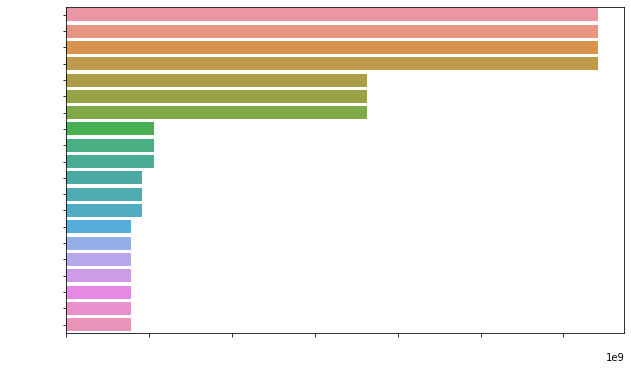

In [75]:
# 타겟을 로그변환하고, 그것을 반영하여 학습, 테스트하고 중요도를 시각화하는 사용자 함수를 작성.

def model_eval_log(model,X,y):
    y_log = np.log1p(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=0)
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    y_test_exp = np.expm1(y_test)
    pred_exp = np.expm1(pred)
    print(model)
    # print(model.__class__.__name__) # 이름이 주저리 주저리 나올 경우
    get_eval(y_test_exp ,pred_exp)
    print()
    coef = pd.Series(model.coef_, index=X.columns)
    coef_sort = coef.sort_values(ascending=False)[:20]
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ### 다크모드에서 축색변경
    [t.set_color('white') for t in ax.xaxis.get_ticklabels()]
    [t.set_color('white') for t in ax.yaxis.get_ticklabels()]
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ###
    ax = sns.barplot(x=coef_sort.values, y=coef_sort.index)
    plt.show()
    plt.close()

lr_reg = LinearRegression()
model_eval_log(lr_reg,X,y)

Ridge(alpha=10)
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893



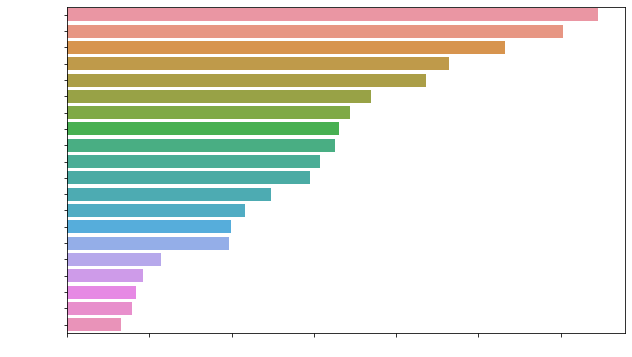

In [76]:
ridge_reg = Ridge(alpha=10)
model_eval_log(ridge_reg,X,y)

Lasso(alpha=0.01)
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803



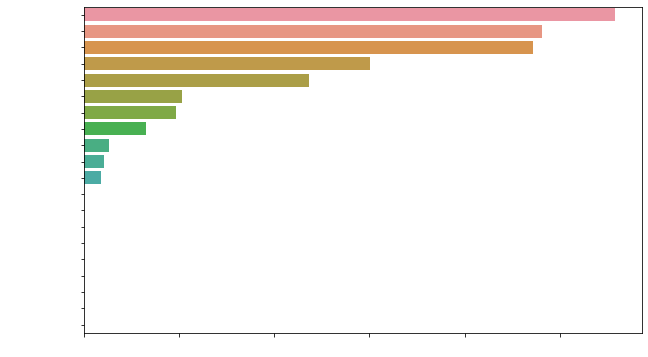

In [77]:
lasso_reg = Lasso(alpha=0.01)
model_eval_log(lasso_reg,X,y)